# Applying a pretrained pipeline

In this tutorial, you will learn how to apply `pyannote.audio` pipelines on an audio file.

A pipeline takes an audio file as input and returns a labeled temporal segmentation of the audio file. 

More precisely, it usually applies a pretrained model (= neural network) on the audio file, post-processes the output of the model, and returns its output as a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance. It should become clearer as you keep reading...

## Loading pipeline from 🤗 hub

Pretrained pipelines are available on [🤗 Huggingface model hub](https://hf.co/models?other=pyannote-audio-pipeline) and can be listed by looking for the [`pyannote-audio-pipeline`](https://hf.co/models?other=pyannote-audio-pipeline) tag.

In [1]:
from huggingface_hub import HfApi
available_pipelines = [p.modelId for p in HfApi().list_models(filter="pyannote-audio-pipeline")]
available_pipelines

['pyannote/overlapped-speech-detection',
 'pyannote/speaker-diarization',
 'pyannote/voice-activity-detection']

Let's load the speaker diarization pipeline...

In [10]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

## Processing a file from disk

... and apply it to an audio file.  

The pipeline will automatically use GPUs when available. 
On CPU it might take a long while (up to 10x RT).

In [3]:
ROOT_DIR = "/Users/bredin/Development/pyannote/pyannote-audio"
AUDIO_FILE = f"{ROOT_DIR}/tutorials/assets/sample.wav"
dia = pipeline(AUDIO_FILE)

## Visualizing the output

Most pipelines return a [`pyannote.core.Annotation`](http://pyannote.github.io/pyannote-core/structure.html#annotation) instance...

In [4]:
from pyannote.core import Annotation
assert isinstance(dia, Annotation)

... whose [API](https://pyannote.github.io/pyannote-core/structure.html#annotation) you can use to print the result:

In [5]:
for speech_turn, track, speaker in dia.itertracks(yield_label=True):
    print(f"{speech_turn.start:4.1f} {speech_turn.end:4.1f} {speaker}")

 6.7  7.1 SPEAKER_01
 7.5  8.2 SPEAKER_00
 8.2 10.0 SPEAKER_01
 9.9 11.0 SPEAKER_00
10.6 14.7 SPEAKER_01
14.3 17.9 SPEAKER_00
18.0 21.5 SPEAKER_01
18.1 18.6 SPEAKER_00
21.7 28.5 SPEAKER_00
27.8 29.7 SPEAKER_01


If you happen to be running this example in a _Jupyter notebook_, `dia` can be [visualized directly](http://pyannote.github.io/pyannote-core/visualization.html):

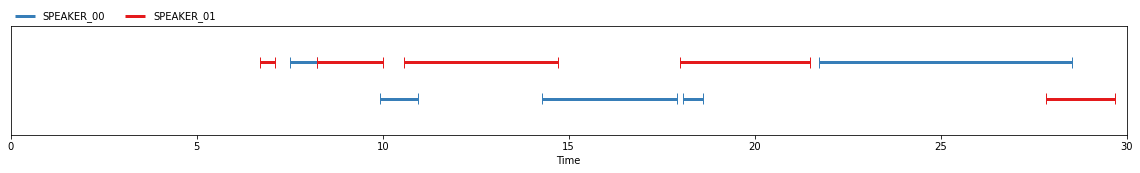

In [6]:
# we visualize [0, 30] time range
from pyannote.core import notebook, Segment
notebook.crop = Segment(0, 30)
dia

When available, the reference annotation can be visualized too, for comparison:

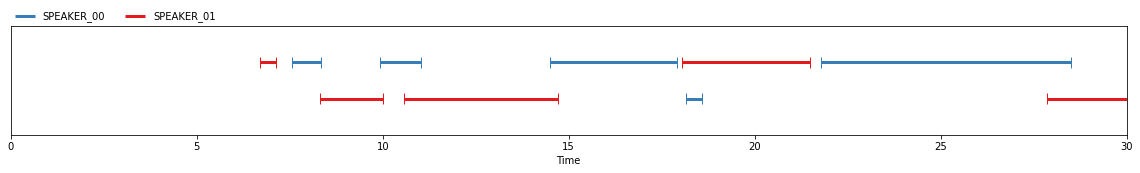

In [7]:
from pyannote.database.util import load_rttm
REFERENCE = f"{ROOT_DIR}/tutorials/assets/sample.rttm"
reference = load_rttm(REFERENCE)["sample"]

# map hypothesized and reference speakers for visualization purposes
pipeline.optimal_mapping(dia, reference)

## Processing a file from memory

In case the audio file is not stored on disk, pipelines can also process audio provided as a `{"waveform": ..., "sample_rate": ...}` dictionary. 

In [8]:
import torchaudio
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print(f"{type(waveform)=}")
print(f"{waveform.shape=}")
print(f"{waveform.dtype=}")

audio_in_memory = {"waveform": waveform, "sample_rate": sample_rate}

type(waveform)=<class 'torch.Tensor'>
waveform.shape=torch.Size([1, 480000])
waveform.dtype=torch.float32


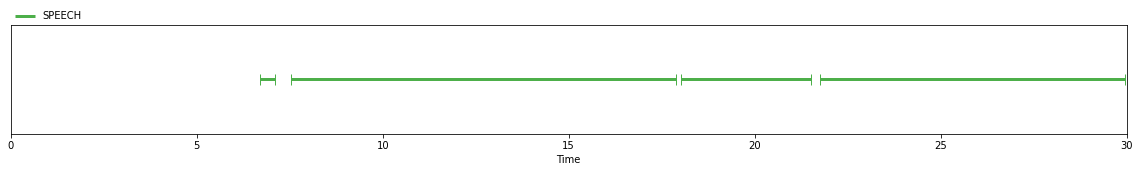

In [9]:
vad = Pipeline.from_pretrained("pyannote/voice-activity-detection")
vad(audio_in_memory)